In [1]:
import os
import numpy as np
import librosa
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Reshape
import librosa
import librosa.display
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Reshape
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
import librosa.display

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Define the path to your dataset in Google Drive
dataset_path = '/content/drive/MyDrive/DATASET'
save_path = '/content/drive/MyDrive'  # This is where melspectrograms will be saved

In [4]:
# Define subfolders
bonafide_path = os.path.join(dataset_path, 'Bonafide')
spoofed_tacotron_path = os.path.join(dataset_path, 'Spoofed_Tacotron')
spoofed_vits_tts_path = os.path.join(dataset_path, 'Spoofed_TTS')

# List all files in the dataset
def list_audio_files(folder_path):
    audio_files = [f for f in os.listdir(folder_path) if f.endswith('.wav')]
    return audio_files

bonafide_files = list_audio_files(bonafide_path)
spoofed_tacotron_files = list_audio_files(spoofed_tacotron_path)
spoofed_vits_tts_files = list_audio_files(spoofed_vits_tts_path)

print("Bonafied files:", bonafide_files)
print("Spoofed Tacotron files:", spoofed_tacotron_files)
print("Spoofed VitsTTS files:", spoofed_vits_tts_files)

Bonafied files: []
Spoofed Tacotron files: []
Spoofed VitsTTS files: []


In [5]:
import os
import numpy as np
import librosa
from tqdm import tqdm

# Configuration
n_mels = 40
max_len = 500  # to ensure shape is (40, 500)
sr = 16000  # Target sample rate
mel_specs = []
labels = []

# Padding/Trimming function
def pad_or_trim(spec, max_len=500):
    if spec.shape[1] > max_len:
        return spec[:, :max_len]
    else:
        pad_width = max_len - spec.shape[1]
        return np.pad(spec, ((0, 0), (0, pad_width)), mode='constant')

# Label map
label_map = {
    'Bonafide': 0,
    'Spoofed_TTS': 1,
    'Spoofed_Tacotron': 1
}

# File storage
audio_files = {
    'Bonafide': [],
    'Spoofed_TTS': [],
    'Spoofed_Tacotron': []
}

# Collect audio file paths
for category in ['Bonafide', 'Spoofed_TTS', 'Spoofed_Tacotron']:
    category_path = os.path.join(dataset_path, category)

    for speaker_folder in os.listdir(category_path):
        speaker_path = os.path.join(category_path, speaker_folder)

        if category == 'Bonafide':
            for part in ['Part 1', 'Part 2']:
                part_path = os.path.join(speaker_path, part)
                if not os.path.isdir(part_path):
                    continue
                for file in tqdm(os.listdir(part_path), desc=f"Processing {category}/{speaker_folder}/{part}"):
                    if file.endswith('.wav'):
                        audio_files[category].append(os.path.join(part_path, file))
        else:
            for file in tqdm(os.listdir(speaker_path), desc=f"Processing {category}/{speaker_folder}"):
                if file.endswith('.wav'):
                    audio_files[category].append(os.path.join(speaker_path, file))

# Process Mel Spectrograms
print("\nExtracting Mel Spectrograms...")

for category in ['Bonafide', 'Spoofed_TTS', 'Spoofed_Tacotron']:
    for file_path in tqdm(audio_files[category], desc=f"Extracting {category}"):
        try:
            audio, _ = librosa.load(file_path, sr=sr)
            mel = librosa.feature.melspectrogram(y=audio, sr=sr, n_mels=n_mels, fmax=8000)
            mel_db = librosa.power_to_db(mel, ref=np.max)
            mel_padded = pad_or_trim(mel_db, max_len)
            mel_specs.append(mel_padded)
            labels.append(label_map[category])
        except Exception as e:
            print(f"⚠️ Failed to process {file_path}: {e}")

# Convert to numpy arrays
mel_specs = np.array(mel_specs)  # shape: (N, 40, 500)
labels = np.array(labels)

# Save to disk
np.save('/content/drive/MyDrive/mel_spectrogram_features.npy', mel_specs)
np.save('/content/drive/MyDrive/mel_spectrogram_labels.npy', labels)

print(f"\n✅ Saved Mel spectrograms: {mel_specs.shape}")
print(f"✅ Saved Labels: {labels.shape}")


Processing Spoofed_Tacotron/Speaker_01: 100%|██████████| 100/100 [00:00<00:00, 420692.48it/s]



Extracting Mel Spectrograms...


Extracting Spoofed_Tacotron: 100%|██████████| 1698/1698 [11:25<00:00,  2.48it/s]



✅ Saved Mel spectrograms: (6814, 40, 500)
✅ Saved Labels: (6814,)


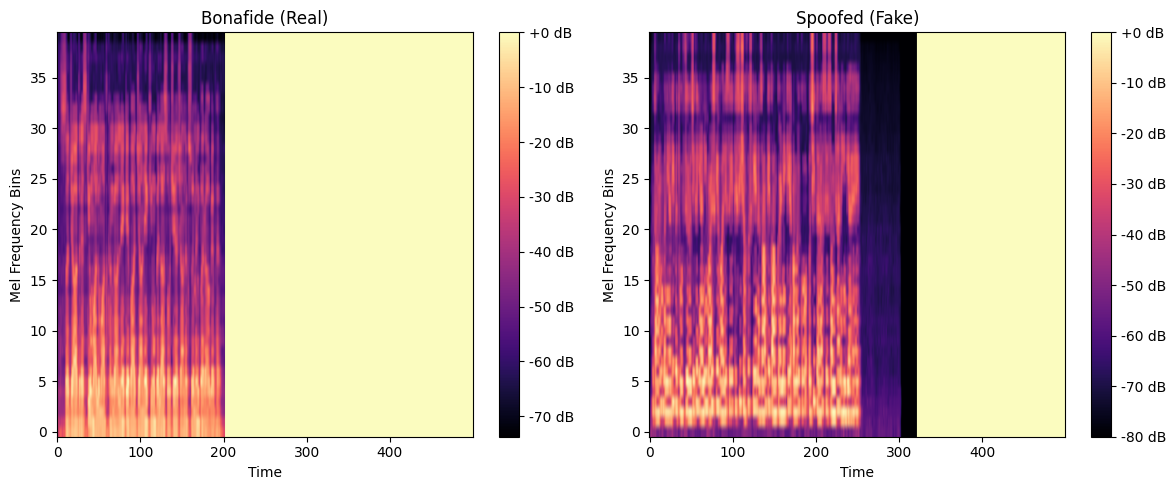

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# Load the data
mel_specs = np.load('/content/drive/MyDrive/mel_spectrogram_features.npy')
labels = np.load('/content/drive/MyDrive/mel_spectrogram_labels.npy')

# Find one example of each class
bonafide_index = np.where(labels == 0)[0][0]  # Real
spoofed_index = np.where(labels == 1)[0][0]   # Fake

# Extract spectrograms
mel_bonafide = mel_specs[bonafide_index]
mel_spoofed = mel_specs[spoofed_index]

# Plot
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.imshow(mel_bonafide, aspect='auto', origin='lower', cmap='magma')
plt.title('Bonafide (Real)')
plt.xlabel('Time')
plt.ylabel('Mel Frequency Bins')
plt.colorbar(format='%+2.0f dB')

plt.subplot(1, 2, 2)
plt.imshow(mel_spoofed, aspect='auto', origin='lower', cmap='magma')
plt.title('Spoofed (Fake)')
plt.xlabel('Time')
plt.ylabel('Mel Frequency Bins')
plt.colorbar(format='%+2.0f dB')

plt.tight_layout()
plt.show()


In [7]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, f1_score, confusion_matrix, roc_curve
from torch.utils.data import DataLoader, TensorDataset
import h5py
import os

# Step 1: Load Mel spectrogram features and labels
mel_path = '/content/drive/MyDrive/mel_spectrogram_features.npy'
labels_path = '/content/drive/MyDrive/mel_spectrogram_labels.npy'
x = np.load(mel_path)          # Shape: (N, 128, 400)
y = np.load(labels_path)

# Step 2: Flatten Mel spectrograms (e.g., 128 x 400 → 51200)
x = x.reshape(x.shape[0], -1)

# Step 3: Train-test split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)

# Step 4: Convert to PyTorch tensors
x_train_tensor = torch.tensor(x_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
x_test_tensor = torch.tensor(x_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Step 5: Create DataLoaders
train_loader = DataLoader(TensorDataset(x_train_tensor, y_train_tensor), batch_size=32, shuffle=True)
test_loader = DataLoader(TensorDataset(x_test_tensor, y_test_tensor), batch_size=32, shuffle=False)

# Step 6: Define the MLP model
class MLP(nn.Module):
    def __init__(self, input_dim=51200, hidden_dim=512, output_dim=2):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Step 7: Initialize model, loss, optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MLP(input_dim=x_train.shape[1]).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Step 8: Training loop
epochs = 12
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        out = model(xb)
        loss = criterion(out, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(train_loader):.4f}")

# Step 9: Evaluation
model.eval()
all_preds, all_probs, all_labels = [], [], []

with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        out = model(xb)
        probs = torch.softmax(out, dim=1)[:, 1].cpu().numpy()
        preds = torch.argmax(out, dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_probs.extend(probs)
        all_labels.extend(yb.numpy())

# Step 10: Metrics
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)
conf_matrix = confusion_matrix(all_labels, all_preds)

# Equal Error Rate (EER)
fpr, tpr, thresholds = roc_curve(all_labels, all_probs)
eer = fpr[np.nanargmin(np.abs(fpr - (1 - tpr)))]

print("\n=== Evaluation Metrics ===")
print(f"Accuracy   : {accuracy:.4f}")
print(f"Precision  : {precision:.4f}")
print(f"F1 Score   : {f1:.4f}")
print(f"EER        : {eer:.4f}")
print("Confusion Matrix:")
print(conf_matrix)

# Step 11: Save model weights
torch.save(model.state_dict(), "/content/drive/MyDrive/mlp_mel_model.pth")
save_path = '/content/drive/MyDrive/mlp_mel_model_weights.h5'
with h5py.File(save_path, 'w') as hf:
    for name, param in model.state_dict().items():
        hf.create_dataset(name, data=param.cpu().numpy())

print(f"\n✅ MLP model trained on Mel spectrograms saved to: {save_path}")


Epoch 1/12, Loss: 10.3438
Epoch 2/12, Loss: 0.6557
Epoch 3/12, Loss: 0.5217
Epoch 4/12, Loss: 0.5829
Epoch 5/12, Loss: 0.5862
Epoch 6/12, Loss: 0.5633
Epoch 7/12, Loss: 0.6014
Epoch 8/12, Loss: 0.5368
Epoch 9/12, Loss: 0.5022
Epoch 10/12, Loss: 0.4971
Epoch 11/12, Loss: 0.4848
Epoch 12/12, Loss: 0.5079

=== Evaluation Metrics ===
Accuracy   : 0.7689
Precision  : 0.7528
F1 Score   : 0.7748
EER        : 0.2193
Confusion Matrix:
[[506 178]
 [137 542]]

✅ MLP model trained on Mel spectrograms saved to: /content/drive/MyDrive/mlp_mel_model_weights.h5


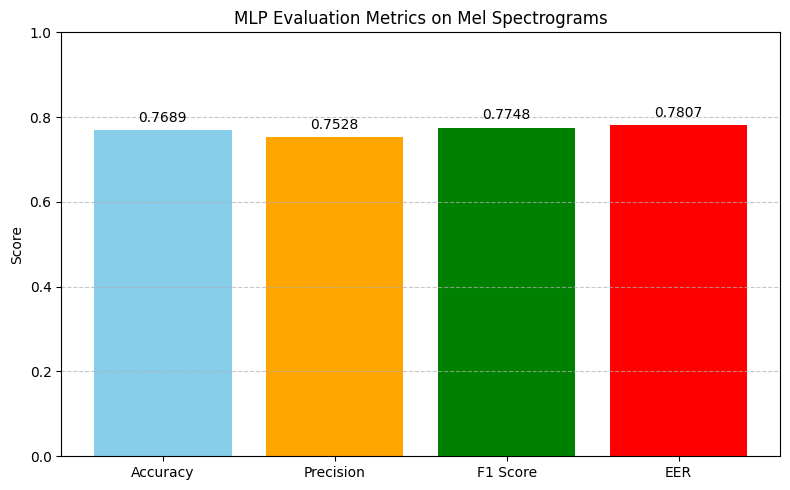

In [8]:
import matplotlib.pyplot as plt

# Metrics to visualize
metrics = {
    'Accuracy': accuracy,
    'Precision': precision,
    'F1 Score': f1,
    'EER': 1 - eer  # Lower EER is better, so we invert it for visual consistency
}

# Plotting
plt.figure(figsize=(8, 5))
plt.bar(metrics.keys(), metrics.values(), color=['skyblue', 'orange', 'green', 'red'])
plt.title("MLP Evaluation Metrics on Mel Spectrograms")
plt.ylabel("Score")
plt.ylim(0, 1)
for i, (k, v) in enumerate(metrics.items()):
    plt.text(i, v + 0.02, f"{v:.4f}", ha='center', fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


Pre trained VIT on mel spectrograms


In [9]:
import os
import torch
import torchaudio
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torchvision import models
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score, precision_score, f1_score
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt


In [12]:
import numpy as np
import torch
import h5py
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, f1_score, confusion_matrix, roc_curve
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
import torch.nn.functional as F
import cv2
import os

# Step 1: Load mel spectrograms and labels
mel_path = '/content/drive/MyDrive/mel_spectrogram_features.npy'   # (N, 128, 400)
labels_path = '/content/drive/MyDrive/mel_spectrogram_labels.npy'  # (N,)
x = np.load(mel_path)
y = np.load(labels_path)

# Step 2: Train-test split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)

# Step 3: Define custom dataset
class MelSpecDataset(Dataset):
    def __init__(self, x, y, transform=None):
        self.x = x
        self.y = y
        self.transform = transform

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        mel = self.x[idx]  # (128, 400)

        # Resize to (224, 224) and normalize to [0, 1]
        mel_img = cv2.resize(mel, (224, 224))
        mel_img = np.stack([mel_img] * 3, axis=0)  # (3, 224, 224)

        if self.transform:
            mel_img = self.transform(torch.tensor(mel_img).float())

        label = self.y[idx]
        return mel_img, torch.tensor(label, dtype=torch.long)

# Step 4: Data transformations
transform = transforms.Compose([
    transforms.Normalize([0.5]*3, [0.5]*3)  # Normalize to [-1, 1]
])

# Step 5: Create DataLoaders
train_dataset = MelSpecDataset(x_train, y_train, transform=transform)
test_dataset = MelSpecDataset(x_test, y_test, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Step 6: Load pre-trained ViT model
model = models.vit_b_16(pretrained=True)
model.heads.head = nn.Linear(model.heads.head.in_features, 2)  # For binary classification

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Step 7: Training setup
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Step 8: Training loop
epochs = 5
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for xb, yb in train_loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        out = model(xb)
        loss = criterion(out, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(train_loader):.4f}")

# Step 9: Evaluation
model.eval()
all_preds, all_probs, all_labels = [], [], []
with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        out = model(xb)
        probs = F.softmax(out, dim=1)[:, 1].cpu().numpy()
        preds = torch.argmax(out, dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_probs.extend(probs)
        all_labels.extend(yb.numpy())

# Step 10: Metrics
from sklearn.metrics import accuracy_score, precision_score, f1_score, confusion_matrix, roc_curve

acc = accuracy_score(all_labels, all_preds)
prec = precision_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)
conf = confusion_matrix(all_labels, all_preds)
fpr, tpr, _ = roc_curve(all_labels, all_probs)
eer = fpr[np.nanargmin(np.abs(fpr - (1 - tpr)))]

print("\n=== Evaluation ===")
print(f"Accuracy   : {acc:.4f}")
print(f"Precision  : {prec:.4f}")
print(f"F1 Score   : {f1:.4f}")
print(f"EER        : {eer:.4f}")
print("Confusion Matrix:\n", conf)
# Save model as .pth file
pth_path = "/content/drive/MyDrive/vit_mel_model.pth"
torch.save(model.state_dict(), pth_path)
print(f"✅ Model saved to: {pth_path}")
# Save model weights as .h5
h5_path = "/content/drive/MyDrive/vit_mel_model.h5"
with h5py.File(h5_path, 'w') as hf:
    for name, param in model.state_dict().items():
        hf.create_dataset(name, data=param.cpu().numpy())
print(f"✅ Model weights saved to: {h5_path}")

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:02<00:00, 160MB/s]


Epoch 1/5, Loss: 0.7328
Epoch 2/5, Loss: 0.6840
Epoch 3/5, Loss: 0.6756
Epoch 4/5, Loss: 0.6697
Epoch 5/5, Loss: 0.5959

=== Evaluation ===
Accuracy   : 0.7821
Precision  : 0.7842
F1 Score   : 0.7802
EER        : 0.2178
Confusion Matrix:
 [[539 145]
 [152 527]]
✅ Model saved to: /content/drive/MyDrive/vit_mel_model.pth
✅ Model weights saved to: /content/drive/MyDrive/vit_mel_model.h5
